Here I will try to create as good model for predicting numbers from pictures as possible

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

from sklearn.datasets import load_digits #import digits data

Let's see how our data looks like

In [2]:
digits = load_digits()
print("shape of digits images data: ", digits.images.shape)

shape of digits images data:  (1797, 8, 8)


Examples of digits from our data set:


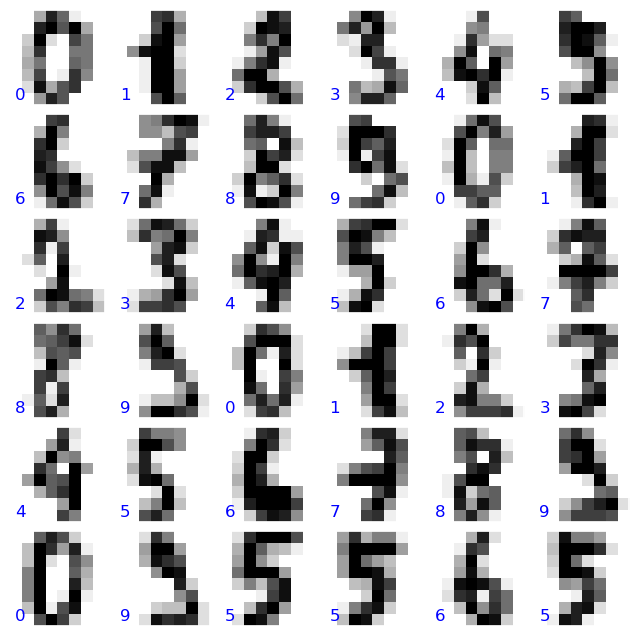

In [3]:
fig, axes = plt.subplots(6, 6, figsize=(8, 8),subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
    transform=ax.transAxes, color='blue')


print("Examples of digits from our data set:")
    

Firstly lets see how Naive Bayes will work

In [4]:
#split the data into train and test set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,random_state=42)

#import Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

#train the model 
model.fit(Xtrain,ytrain)


GaussianNB()

Lets evaluate how the model worked.

I will write just acuracy score but at the end I will compare all models on which I have trained this data with confussion matrixes.

In [5]:
from sklearn.metrics import accuracy_score

#give labels to new data with the use of trained model
y_gaussian = model.predict(Xtest)

#evaluate accuracy score
print("accuracy score of NB Gaussian model: ", accuracy_score(ytest, y_gaussian))

accuracy score of NB Gaussian model:  0.8555555555555555


Not bad, but lets see how other models will work

But now I'll firstly preprocess data with the PCA, to reduce the number of dimensions from 8x8 to a value that will be enough for representing most of the information needed about the data.

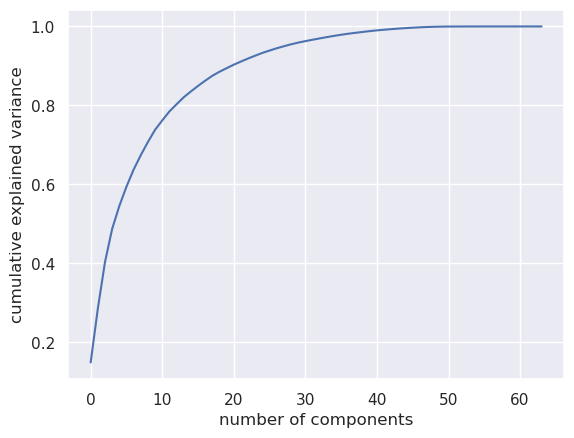

In [6]:
#import PCA
from sklearn.decomposition import PCA

#lets see how many PCA components will be enough
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It looks that 50 dimensions should do the job.

Now I will firstly use PCA to reduce the number of dimensions of the data to 50 and then I will use SVC model for predicting task.

In [7]:
from sklearn.pipeline import make_pipeline

#import SVC model
from sklearn.svm import SVC

#split the data
Xtrain_pca, Xtest_pca, y_train_pca, ytest_pca =  train_test_split(digits.data, digits.target,
random_state=42)

#create pipeline
pca = PCA(n_components=50, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model_pca = make_pipeline(pca, svc)

In [8]:
#use Gridsearch CV to find the best model params
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50], #decides about the margin width
'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}#controls the size ofradial basis function

grid = GridSearchCV(model_pca, param_grid)

In [9]:
grid.fit(Xtrain_pca, y_train_pca)
print("Best params found by gridsearch :", grid.best_params_)

Best params found by gridsearch : {'svc__C': 10, 'svc__gamma': 0.005}


In [10]:
#lets predict labels on the best hyperparams
model_svc = grid.best_estimator_
y_SVC = model_svc.predict(Xtest_pca)

#print accuracy score achieved by SVC
print("Accuracy score achieved by SVC model: ", accuracy_score(ytest_pca, y_SVC))

Accuracy score achieved by SVC model:  0.9844444444444445


it did suprisingly well!! (I checked if i didnt train on the Xtest_pca set)

Now i will se how it will work with the random forest model


In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=2000)
model.fit(Xtrain_pca, y_train_pca)
y_RFC = model.predict(Xtest_pca)

print("Accuracy score of Random Forest Classifier: ", accuracy_score(ytest_pca, y_RFC))

Accuracy score of Random Forest Classifier:  0.9755555555555555


Lets evaluate all of those 3 models

Predicted vs True labels for different models


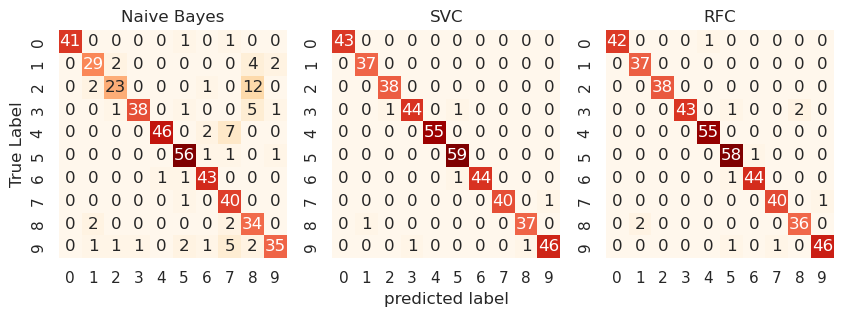

In [43]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1,3, figsize = (10,5))

#confusion matrix for Naive Bayes
mat = confusion_matrix(ytest, y_gaussian)
sns.heatmap(mat,annot=True , square = True, cbar=False, ax=ax[0], cmap='OrRd')
ax[0].set( ylabel="True Label", title = "Naive Bayes")

#confussion matrix for SVC
mat_SVC = confusion_matrix(ytest_pca, y_SVC)
sns.heatmap(mat_SVC,annot=True , square = True, cbar=False, ax=ax[1], cmap='OrRd')
ax[1].set(xlabel="predicted label", title = "SVC")

#confussion matrix for RFC
mat_RFC = confusion_matrix(ytest_pca, y_RFC)
sns.heatmap(mat_RFC,annot=True , square = True, cbar=False, ax=ax[2], cmap='OrRd')
ax[2].set(title = "RFC")

print("Predicted vs True labels for different models")




Inspired by: Python Data Science Handbook by Jake VanderPlas